In [36]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/src/MA_Diffusion_base_trajectory_prediction')

from utils.data_utils import TDRIVE, GEOLIFE, load_data, calculate_bbox_and_filter, \
    plot_coordinates, plot_paths, load_new_format, find_cycles, split_cycle_in_paths, \
    plot_histograms_before_after_split, \
    get_edge_used_by_trajectories, modify_and_save_data

from utils.shortest_path import calculate_shortest_paths

# Data Loading

In [37]:
GEOLIFE_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/geolife.h5'
TDRIVE_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive.h5'
MUNICH_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich.h5'
# pNEUMA dataset is not in the correct format yet
PNEUMA_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pNEUMA.h5'
datasets = [GEOLIFE_PATH, TDRIVE_PATH, MUNICH_PATH]

In [38]:
'''paths, node_coordinates, edges = load_new_format(TDRIVE_PATH)
edge_coordinates = node_coordinates[edges]
'''

'paths, node_coordinates, edges = load_new_format(TDRIVE_PATH)\nedge_coordinates = node_coordinates[edges]\n'

# Calculate Shortest Paths for all existing actual paths in dataset

In [39]:
def calculate_shared_edge_ratio(shortest_paths, actual_paths, edges):
    total_ratio = 0
    for shortest_path, actual_path in zip(shortest_paths, actual_paths):
        shortest_edges = [tuple(edge) for edge in edges[shortest_path['edge_idxs']]]
        actual_edges = [tuple(edge) for edge in edges[actual_path['edge_idxs']]]
        shared_edges = set(shortest_edges) & set(actual_edges)
        ratio = len(shared_edges) / len(actual_edges)
        total_ratio += ratio
    average_ratio = total_ratio / len(shortest_paths)
    return average_ratio

In [40]:
def calculate_path_distances(shortest_paths, actual_paths, node_coordinates, edges):
    ## Actual Paths
    # Calculate distance in terms of # edges
    actual_path_lengths = [len(path['edge_idxs']) for path in actual_paths]
    mean_actual_path_length = np.mean(actual_path_lengths)
    median_actual_path_length = np.median(actual_path_lengths)
    # Calculate distance in terms of euclidean distance
    actual_euclidean_lengths = np.zeros(len(actual_paths))
    for j, path in enumerate(actual_paths):
        euclidean_length = 0
        for i in range(len(path['edge_idxs'])):
            edge_idx = path['edge_idxs'][i]
            edge_coordinates = node_coordinates[edges[edge_idx]]
            euclidean_length += np.linalg.norm(edge_coordinates[1] - edge_coordinates[0])
        actual_euclidean_lengths[j] = euclidean_length
    mean_actual_euclidean_path_length = np.mean(actual_euclidean_lengths)
    median_actual_euclidean_path_length = np.median(actual_euclidean_lengths)
    
    ## Shortest Paths
    # Calculate distance in terms of # edges
    shortest_path_lengths = [len(path['edge_idxs']) for path in shortest_paths]
    mean_shortest_path_length = np.mean(shortest_path_lengths)
    median_shortest_path_length = np.median(shortest_path_lengths)
    # Calculate distance in terms of euclidean distance
    shortest_euclidean_lengths = np.zeros(len(shortest_paths))
    for j, path in enumerate(shortest_paths):
        euclidean_length = 0
        for i in range(len(path['edge_idxs'])):
            edge_idx = path['edge_idxs'][i]
            edge_coordinates = node_coordinates[edges[edge_idx]]
            euclidean_length += np.linalg.norm(edge_coordinates[1] - edge_coordinates[0])
        shortest_euclidean_lengths[j] = euclidean_length
    mean_shortest_euclidean_path_length = np.mean(shortest_euclidean_lengths)
    median_shortest_euclidean_path_length = np.median(shortest_euclidean_lengths)
    
    return (mean_actual_path_length, median_actual_path_length, mean_actual_euclidean_path_length, median_actual_euclidean_path_length, 
            mean_shortest_path_length, median_shortest_path_length, mean_shortest_euclidean_path_length, median_shortest_euclidean_path_length)

## Shortest Paths in Terms of # Edges

In [41]:
import numpy as np
# Calculate mean and median path lengths for actual paths and shortest paths
actual_mean_lengths = []
actual_median_lengths = []
shortest_mean_lengths = []
shortest_median_lengths = []
actual_mean_euclidean_length = []
actual_median_euclidean_length = []
shortest_mean_euclidean_length = []
shortest_median_euclidean_length = []
shared_edges_average = []

for dataset in tqdm(datasets):
    paths, node_coordinates, edges = load_new_format(dataset)
    shortest_paths = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='edge')

    # Calculate mean and median path lengths in number of edges and in euclidean terms
    (mean_actual_path_length, 
        median_actual_path_length, 
        mean_actual_euclidean_path_length, 
        median_actual_euclidean_path_length, 
        mean_shortest_path_length, 
        median_shortest_path_length, 
        mean_shortest_euclidean_path_length, 
        median_shortest_euclidean_path_length) = calculate_path_distances(shortest_paths, paths, node_coordinates, edges)

    # Actual Paths
    actual_mean_lengths.append(mean_actual_path_length)
    actual_median_lengths.append(median_actual_path_length)
    actual_mean_euclidean_length.append(mean_actual_euclidean_path_length)
    actual_median_euclidean_length.append(median_actual_euclidean_path_length)

    # Shortest Paths
    shortest_mean_lengths.append(mean_shortest_path_length)
    shortest_median_lengths.append(median_shortest_path_length)
    shortest_mean_euclidean_length.append(mean_shortest_euclidean_path_length)
    shortest_median_euclidean_length.append(median_shortest_euclidean_path_length)

    # Shared edges
    average_ratio = calculate_shared_edge_ratio(shortest_paths, paths, edges)
    shared_edges_average.append(average_ratio)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:13<00:00, 64.41s/it]


### Number of Edges

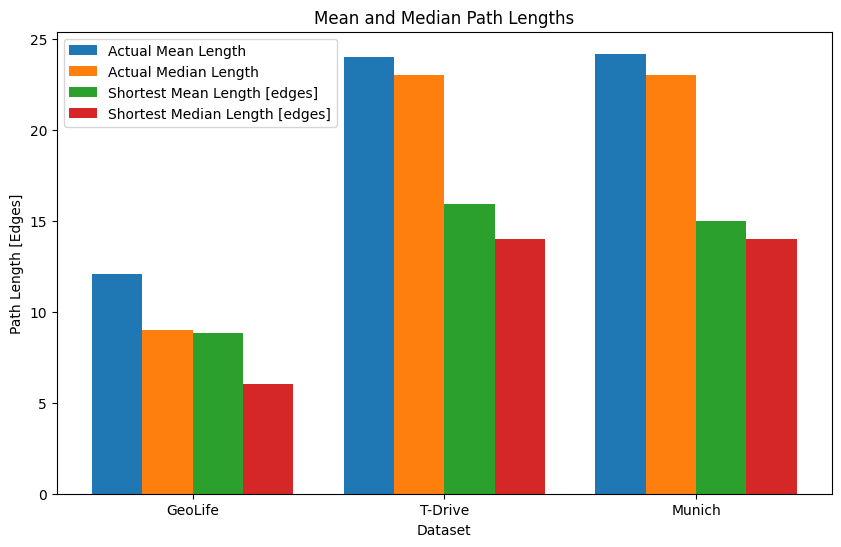

In [42]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_lengths, bar_width, label='Actual Mean Length')
plt.bar(index + bar_width, actual_median_lengths, bar_width, label='Actual Median Length')
plt.bar(index + 2 * bar_width, shortest_mean_lengths, bar_width, label='Shortest Mean Length [edges]')
plt.bar(index + 3 * bar_width, shortest_median_lengths, bar_width, label='Shortest Median Length [edges]')

plt.xticks(index + 1.5 * bar_width, ['GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Edges]')
plt.title('Mean and Median Path Lengths')
plt.legend()
plt.show()

### Euclidean Path Lengths

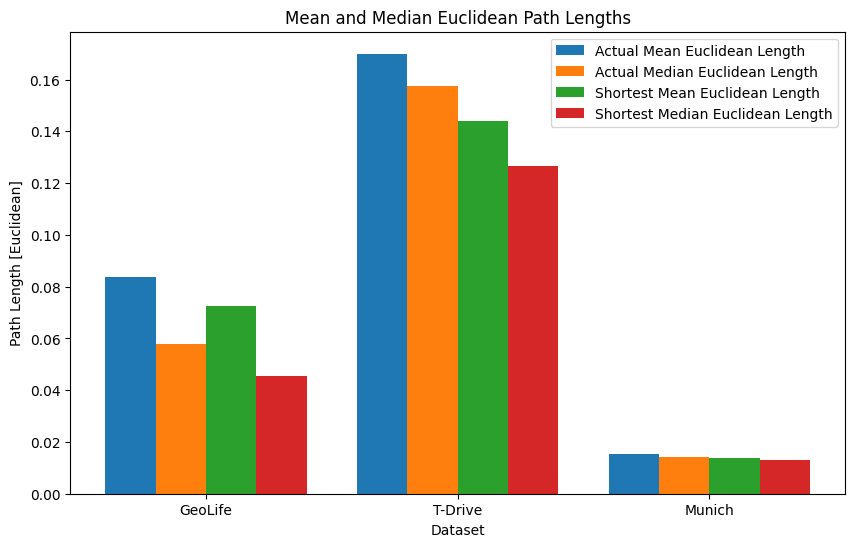

In [43]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_euclidean_length, bar_width, label='Actual Mean Euclidean Length')
plt.bar(index + bar_width, actual_median_euclidean_length, bar_width, label='Actual Median Euclidean Length')
plt.bar(index + 2 * bar_width, shortest_mean_euclidean_length, bar_width, label='Shortest Mean Euclidean Length')
plt.bar(index + 3 * bar_width, shortest_median_euclidean_length, bar_width, label='Shortest Median Euclidean Length')

plt.xticks(index + 1.5 * bar_width, ['GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Euclidean]')
plt.title('Mean and Median Euclidean Path Lengths')
plt.legend()
plt.show()

In [44]:
print("Using edge weighting of 1:")
for i, dataset in enumerate(datasets):
    print("Dataset:", str(dataset).split('/')[-1].split('.')[0])
    print(f"Average length of actual paths: {np.round(actual_mean_lengths[i], 2)} edges, or {round(actual_mean_euclidean_length[i], 4)} in euclidean length")
    print(f"Average length of shortest paths: {np.round(shortest_mean_lengths[i], 2)} edges, or {round(shortest_mean_euclidean_length[i], 4)} in euclidean length")
    print(f'Actual paths have on average {round(actual_mean_lengths[i] / shortest_mean_lengths[i], 2)} times more edges than the shortest available paths')
    print(f'Actual paths are on average {round(actual_mean_euclidean_length[i] / shortest_mean_euclidean_length[i], 2)} times longer in euclidean distance than the shortest available paths (euclidean)')
    print("Average ratio of shared edges:", np.round(shared_edges_average[i], 4))
    print("\n")

Using edge weighting of 1:
Dataset: geolife
Average length of actual paths: 12.06 edges, or 0.0837 in euclidean length
Average length of shortest paths: 8.81 edges, or 0.0725 in euclidean length
Actual paths have on average 1.37 times more edges than the shortest available paths
Actual paths are on average 1.15 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.424


Dataset: tdrive
Average length of actual paths: 24.01 edges, or 0.17 in euclidean length
Average length of shortest paths: 15.92 edges, or 0.1439 in euclidean length
Actual paths have on average 1.51 times more edges than the shortest available paths
Actual paths are on average 1.18 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.2854


Dataset: munich
Average length of actual paths: 24.17 edges, or 0.0152 in euclidean length
Average length of shortest paths: 14.99 edges, or 0.0139 in euclidean l

## Shortest Paths in Terms of Euclidean Distance

In [45]:
import numpy as np
# Calculate mean and median path lengths for actual paths and shortest paths
actual_mean_lengths = []
actual_median_lengths = []
shortest_mean_lengths = []
shortest_median_lengths = []
actual_mean_euclidean_length = []
actual_median_euclidean_length = []
shortest_mean_euclidean_length = []
shortest_median_euclidean_length = []
shared_edges_average = []

for dataset in tqdm(datasets):
    paths, node_coordinates, edges = load_new_format(dataset)
    shortest_paths = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='euclidean')
    
    # Calculate mean and median path lengths in number of edges and in euclidean terms
    (mean_actual_path_length, 
     median_actual_path_length, 
     mean_actual_euclidean_path_length, 
     median_actual_euclidean_path_length, 
     mean_shortest_path_length, 
     median_shortest_path_length, 
     mean_shortest_euclidean_path_length, 
     median_shortest_euclidean_path_length) = calculate_path_distances(shortest_paths, paths, node_coordinates, edges)
    
    # Actual Paths
    actual_mean_lengths.append(mean_actual_path_length)
    actual_median_lengths.append(median_actual_path_length)
    actual_mean_euclidean_length.append(mean_actual_euclidean_path_length)
    actual_median_euclidean_length.append(median_actual_euclidean_path_length)
    
    # Shortest Paths
    shortest_mean_lengths.append(mean_shortest_path_length)
    shortest_median_lengths.append(median_shortest_path_length)
    shortest_mean_euclidean_length.append(mean_shortest_euclidean_path_length)
    shortest_median_euclidean_length.append(median_shortest_euclidean_path_length)
    
    # Shared edges
    average_ratio = calculate_shared_edge_ratio(shortest_paths, paths, edges)
    shared_edges_average.append(average_ratio)


100%|██████████| 3/3 [04:13<00:00, 84.60s/it] 


### Number of Edges

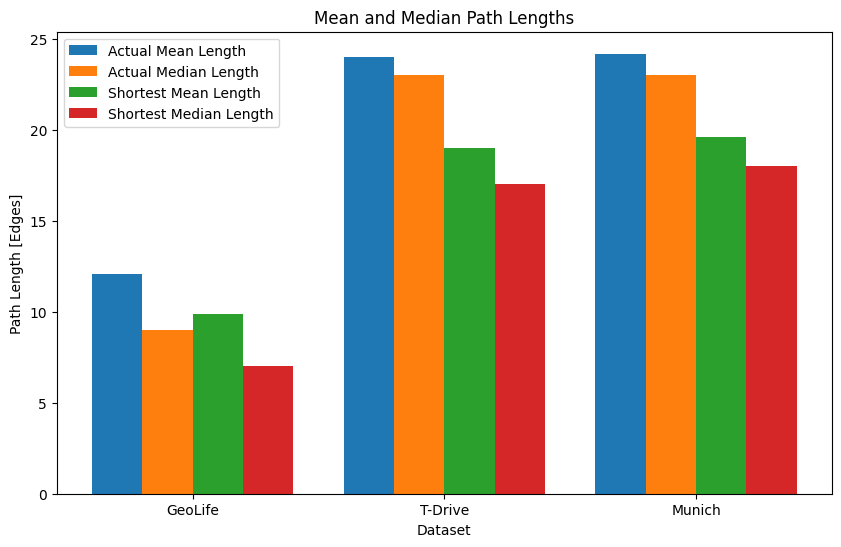

In [51]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_lengths, bar_width, label='Actual Mean Length')
plt.bar(index + bar_width, actual_median_lengths, bar_width, label='Actual Median Length')
plt.bar(index + 2 * bar_width, shortest_mean_lengths, bar_width, label='Shortest Mean Length')
plt.bar(index + 3 * bar_width, shortest_median_lengths, bar_width, label='Shortest Median Length')

plt.xticks(index + 1.5 * bar_width, ['GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Edges]')
plt.title('Mean and Median Path Lengths')
plt.legend()
plt.show()

### Euclidean Path Length

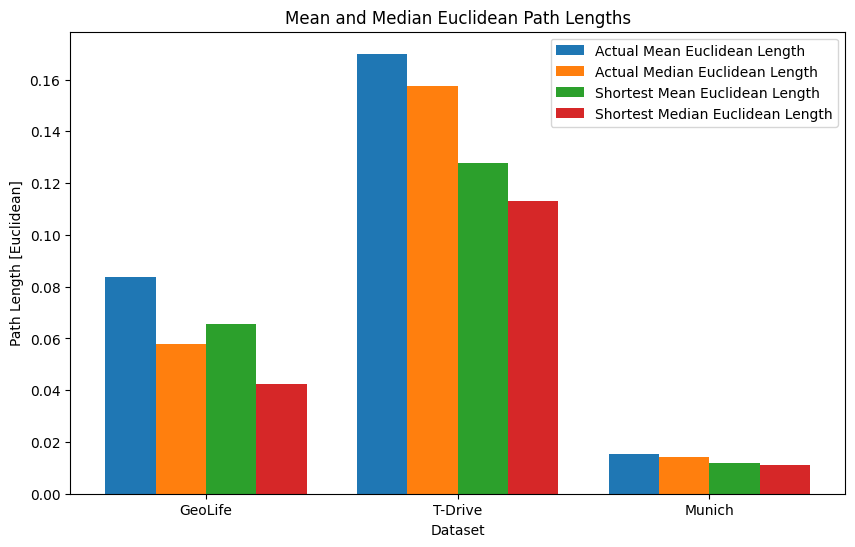

In [52]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_euclidean_length, bar_width, label='Actual Mean Euclidean Length')
plt.bar(index + bar_width, actual_median_euclidean_length, bar_width, label='Actual Median Euclidean Length')
plt.bar(index + 2 * bar_width, shortest_mean_euclidean_length, bar_width, label='Shortest Mean Euclidean Length')
plt.bar(index + 3 * bar_width, shortest_median_euclidean_length, bar_width, label='Shortest Median Euclidean Length')

plt.xticks(index + 1.5 * bar_width, ['GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Euclidean]')
plt.title('Mean and Median Euclidean Path Lengths')
plt.legend()
plt.show()

In [48]:
print("Using edge distance as distance measure")
for i, dataset in enumerate(datasets):
    print("Dataset:", str(dataset).split('/')[-1].split('.')[0])
    print(f"Average length of actual paths: {np.round(actual_mean_lengths[i], 2)} edges, or {round(actual_mean_euclidean_length[i], 4)} in euclidean length")
    print(f"Average length of shortest paths: {np.round(shortest_mean_lengths[i], 2)} edges, or {round(shortest_mean_euclidean_length[i], 4)} in euclidean length")
    print(f'Actual paths have on average {round(actual_mean_lengths[i] / shortest_mean_lengths[i], 2)} times more edges than the shortest available paths')
    print(f'Actual paths are on average {round(actual_mean_euclidean_length[i] / shortest_mean_euclidean_length[i], 2)} times longer in euclidean distance than the shortest available paths (euclidean)')
    print("Average ratio of shared edges:", np.round(shared_edges_average[i], 4))
    print("\n")

Using edge distance as distance measure
Dataset: geolife
Average length of actual paths: 12.06 edges, or 0.0837 in euclidean length
Average length of shortest paths: 9.85 edges, or 0.0655 in euclidean length
Actual paths have on average 1.22 times more edges than the shortest available paths
Actual paths are on average 1.28 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.4757


Dataset: tdrive
Average length of actual paths: 24.01 edges, or 0.17 in euclidean length
Average length of shortest paths: 19.01 edges, or 0.1279 in euclidean length
Actual paths have on average 1.26 times more edges than the shortest available paths
Actual paths are on average 1.33 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.3997


Dataset: munich
Average length of actual paths: 24.17 edges, or 0.0152 in euclidean length
Average length of shortest paths: 19.59 edges, or 0.012 i

## Plot Actual and Shortest Paths

410


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


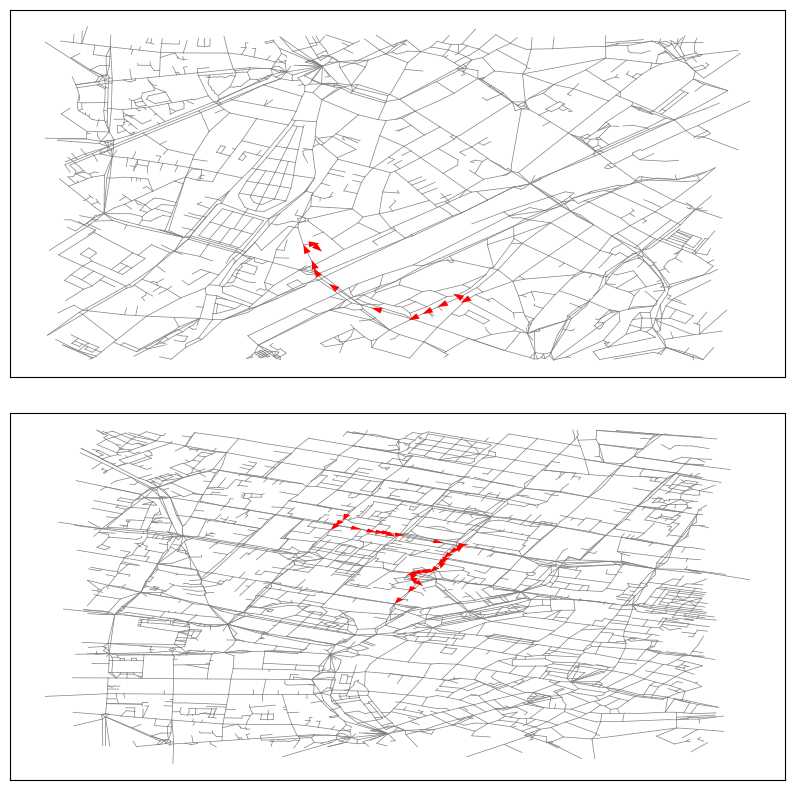

In [57]:
path_id = np.random.randint(low=0, high=len(paths))
print(path_id)
plot_paths(paths, node_coordinates, edges, num_paths_to_plot=2, start_id=path_id)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


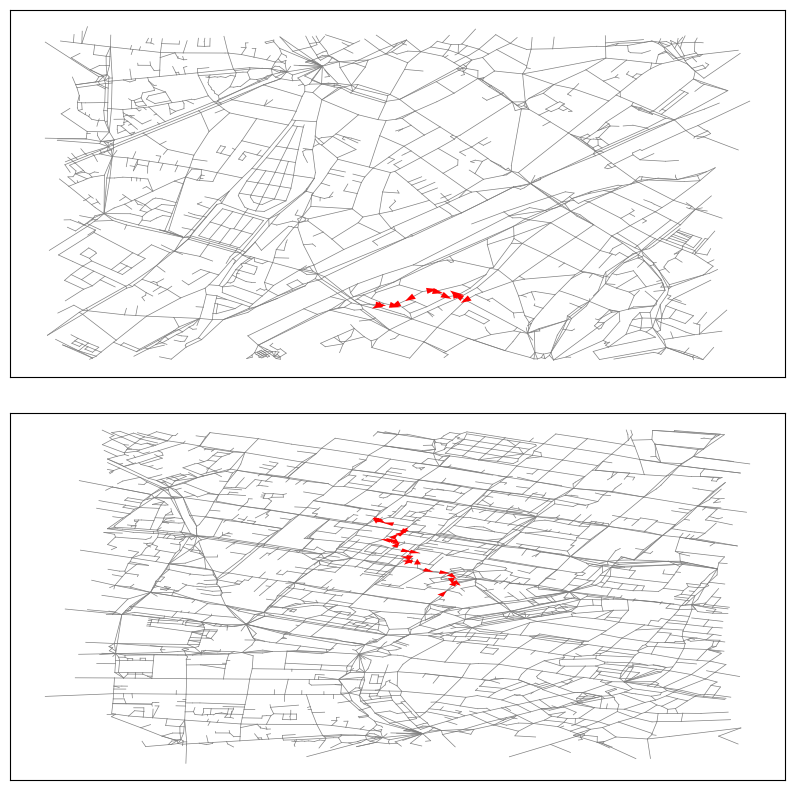

In [58]:
plot_paths(shortest_paths, node_coordinates, edges, num_paths_to_plot=2, start_id=path_id)